En esta sección comenzamos la exploración del dataset que vamos a utilizar para el trabajo práctico.
Elegimos Netflix, que contiene información de 16.000 usuarios y 752 películas.

El objetivo de esta parte es:

* cargar los datos de entrenamiento y test,

* revisar la estructura del DataFrame,

* observar un ejemplo concreto de usuario,

* verificar que los archivos del dataset estén correctamente accesibles.

El archivo netflix8_train.df contiene, para cada usuario:

* su grupo (entre 0 y 7),

* la secuencia de películas vistas (items),

* la secuencia de ratings otorgados (ratings).

El archivo netflix8_test.json contiene usuarios cold-start, que son importantes para evaluar el modelo.

Por último, cargamos también el archivo de centroides de grupos, que sirve para análisis exploratorio y como posible baseline.

In [32]:
import pandas as pd 
import numpy as np 
import json 
import matplotlib.pyplot as plt 
import seaborn as sns 

DATASET = 'netflix' 
NUM_ITEMS = 752 
train_path = '../data/train/netflix8_train.df' 
test_path = '../data/test_users/netflix8_test.json' 
centroids_path = '../data/groups/mu_netflix8.csv' 
item_name = 'películas' 

print(f"📊 Dataset seleccionado: {DATASET.upper()}") 
print(f"📦 Número de items: {NUM_ITEMS} {item_name}") 
print("="*60) 

# === CARGAR TRAINING DATA === 
df_train = pd.read_pickle(train_path) 
print(f"\nNúmero de usuarios: {len(df_train)}") 
print(f"Columnas: {df_train.columns.tolist()}") 
# Ver un usuario ejemplo 
user_0 = df_train.iloc[0] 
print(f"\nUsuario 0:") 
print(f" Grupo: {user_0['user_group']}") 
print(f" # de ratings: {len(user_0['items'])}") 
print(f" Primeros 5 {item_name} vistos: {user_0['items'][:5]}") 
print(f" Primeros 5 ratings: {user_0['ratings'][:5]}") 

# === CARGAR TEST DATA === 
with open(test_path, 'r') as f: test_users = json.load(f) 
print(f"\nNúmero de usuarios de test: {len(test_users)}") 
print(f"\nUsuario de test 0:") 
print(f" Grupo: {test_users[0]['group']}") 
print(f" Rating para item 0: {test_users[0]['ratings'][0]}") 
print(f" Rating para item 100: {test_users[0]['ratings'][100]}") 

# === CARGAR CENTROIDES (OPCIONAL) === 
mu = pd.read_csv(centroids_path, header=None) 
sigma = pd.read_csv('../data/groups/sigma_netflix8.csv', header=None)
print(f"\nCentroides shape: {mu.shape}") # (8, NUM_ITEMS) 
print(f"Rating promedio del grupo 0 para item 0: {mu.iloc[0, 0]:.2f}")

📊 Dataset seleccionado: NETFLIX
📦 Número de items: 752 películas

Número de usuarios: 16000
Columnas: ['user_id', 'user_group', 'items', 'ratings']

Usuario 0:
 Grupo: 0
 # de ratings: 77
 Primeros 5 películas vistos: [472  97 122 654 709]
 Primeros 5 ratings: [4. 3. 4. 3. 5.]

Número de usuarios de test: 1600

Usuario de test 0:
 Grupo: 0
 Rating para item 0: 4
 Rating para item 100: 3

Centroides shape: (8, 752)
Rating promedio del grupo 0 para item 0: 3.53


📊 Distribución de longitudes de secuencias

Analizamos cuántas interacciones (películas calificadas) tiene cada usuario.

Este análisis es importante porque:

* determina cuánta información histórica tiene cada usuario,

* condiciona el tamaño del contexto que puede aprender el modelo,

* y permite elegir un context_length razonable para el Decision Transformer.


Longitud mínima: 25
Longitud promedio: 112.35075
Longitud máxima: 200


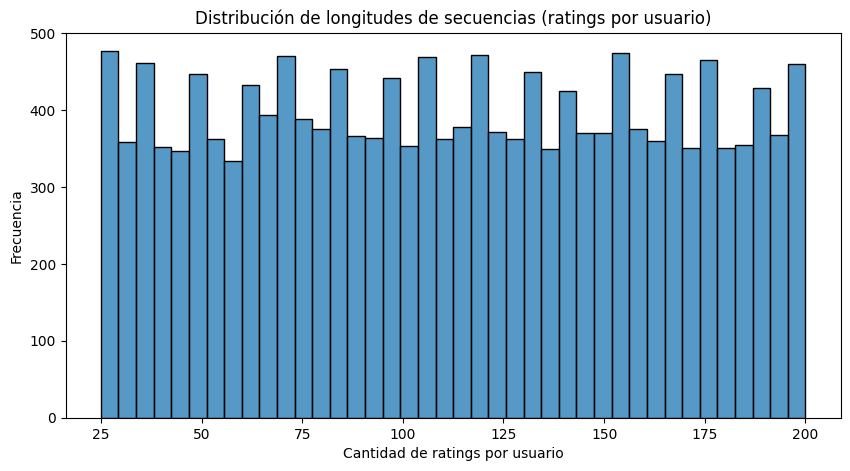

In [33]:
# Longitud de secuencia por usuario
seq_lengths = df_train["items"].apply(len)

print("Longitud mínima:", seq_lengths.min())
print("Longitud promedio:", seq_lengths.mean())
print("Longitud máxima:", seq_lengths.max())

plt.figure(figsize=(10,5))
sns.histplot(seq_lengths, bins=40, kde=False)
plt.title("Distribución de longitudes de secuencias (ratings por usuario)")
plt.xlabel("Cantidad de ratings por usuario")
plt.ylabel("Frecuencia")
plt.show()



La mayoría de los usuarios tienen entre 25 y 200 interacciones registradas.

Este comportamiento es ideal para un modelo secuencial como el Decision Transformer porque: permite capturar patrones temporales en el historial del usuario, garantiza que hay suficiente información para generar representaciones útiles y justifica el uso de un context length (ventana temporal) fijo como parámetro de entrenamiento.

⭐ Distribución global de ratings

Analizamos cuántas veces aparece cada rating (1 a 5) en el dataset.

Rating promedio global: 3.2160811120531014


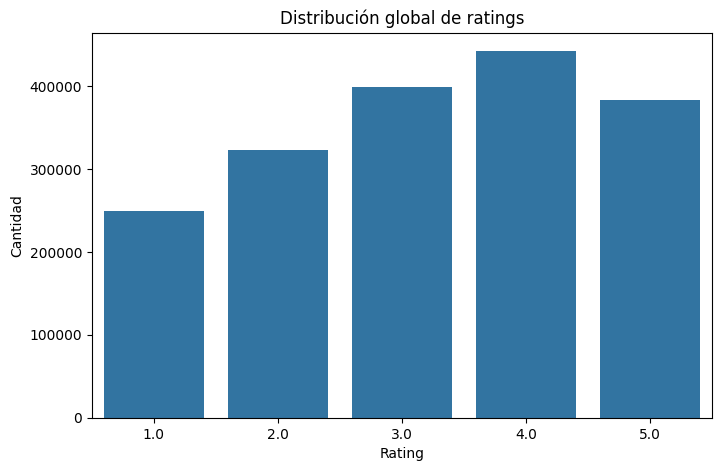

In [34]:
all_ratings = np.concatenate(df_train["ratings"].values)

print("Rating promedio global:", all_ratings.mean())

plt.figure(figsize=(8,5))
sns.countplot(x=all_ratings)
plt.title("Distribución global de ratings")
plt.xlabel("Rating")
plt.ylabel("Cantidad")
plt.show()



La distribución tiene una forma ascendente hacia los valores medios y altos, lo que indica un sesgo positivo típico en sistemas de recomendación: los usuarios tienden a calificar más alto las películas que ven.

El rating promedio global es 3.21, lo cual confirma que la mayoría de las valoraciones son neutras o positivas, y que los ratings realmente bajos son menos frecuentes.


🍿 Películas más populares del dataset

Analizamos las 20 películas más frecuentemente evaluadas por los usuarios.


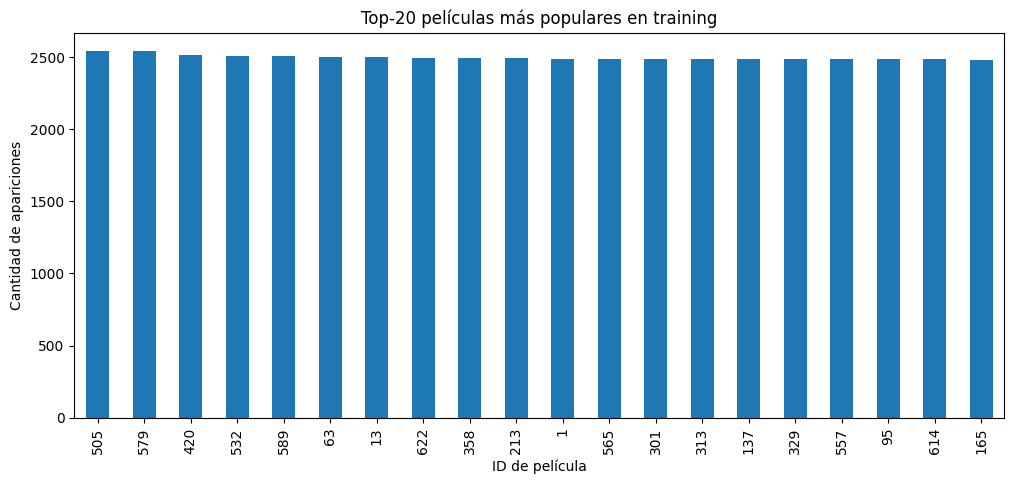

In [35]:
all_items = np.concatenate(df_train["items"].values)
item_counts = pd.Series(all_items).value_counts().sort_values(ascending=False)

plt.figure(figsize=(12,5))
item_counts.head(20).plot(kind="bar")
plt.title("Top-20 películas más populares en training")
plt.xlabel("ID de película")
plt.ylabel("Cantidad de apariciones")
plt.show()


El gráfico muestra las 20 películas más frecuentes en el conjunto de entrenamiento. Cada barra representa cuántas veces aparece una película en las secuencias de los usuarios.

Se observa que todas las películas del Top-20 tienen una cantidad muy similar de apariciones (alrededor de ~2500), lo que indica que existe un conjunto de títulos altamente populares dentro del sistema.

El dataset presenta una marcada concentración de popularidad en ciertos títulos, lo cual influye directamente en el comportamiento y desempeño de los modelos de recomendación

In [14]:
#pip install -q ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [17]:
#!pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 17.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]


🧾 Reporte automático del dataset con ydata-profiling

Vamos a generar un reporte exploratorio automático utilizando la librería ydata-profiling.
Este reporte resume características generales del dataset, como:

* tipos de columnas,

* distribución de valores,

* estadísticas descriptivas,

* detección de valores faltantes,

* relaciones básicas entre variables.

Aunque las columnas items y ratings contienen listas (y no pueden analizarse como columnas numéricas normales), el reporte sigue siendo útil para obtener una visión general del dataset, validar su estructura y revisar rápidamente posibles inconsistencias.


In [36]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df_train, title="Reporte de datos (Netflix)", explorative=True)
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00, 51.81it/s]


Construimos el dataset en formato Decision Transformer, que es el formato que necesita el modelo para entrenar.
El archivo original (df_train) contiene, para cada usuario, una secuencia de películas y sus ratings.
Pero el Decision Transformer no trabaja con DataFrames: requiere trayectorias, es decir, una lista de diccionarios donde cada diccionario representa la historia completa de un usuario.

Definimos la función create_dt_dataset() la cual hace exactamente eso lee cada usuario del dataset, extrae su secuencia de items (películas vistas), extrae sus ratings, calcula el return-to-go, que es la suma de los ratings futuros desde cada paso.

Genera un vector timesteps para indicar la posición temporal dentro de la secuencia, agrega el user_group para usarlo como embedding, y finalmente devuelve todo como una lista de trayectorias

Este es el formato estándar que vamos a usar luego en el DataLoader y el entrenamiento.

In [25]:
def create_dt_dataset(df_train):
    trajectories = []

    for _, row in df_train.iterrows():
        items = row["items"]
        ratings = row["ratings"]
        group = row["user_group"]

        # returns-to-go (suma hacia adelante)
        returns = np.zeros(len(ratings))
        returns[-1] = ratings[-1]
        for t in range(len(ratings)-2, -1, -1):
            returns[t] = ratings[t] + returns[t+1]

        trajectory = {
            "items": items,
            "ratings": ratings,
            "returns_to_go": returns,
            "timesteps": np.arange(len(items)),
            "user_group": group
        }

        trajectories.append(trajectory)

    return trajectories

trajectories = create_dt_dataset(df_train)
print("Total trayectorias:", len(trajectories))
print("Keys primera trayectoria:", trajectories[0].keys())


Total trayectorias: 16000
Keys primera trayectoria: dict_keys(['items', 'ratings', 'returns_to_go', 'timesteps', 'user_group'])


Antes de continuar con el entrenamiento, es importante verificar que el preprocesamiento del dataset se realizó correctamente.
En esta celda revisamos si la primera trayectoria construida cumple con todas las condiciones necesarias para que el Decision Transformer pueda entrenar sin errores.

Los chequeos que hacemos son:

* items y ratings tienen el mismo largo?
Cada película debe tener su rating correspondiente.

* returns-to-go tiene el mismo largo que la secuencia?
Porque para cada paso temporal el modelo necesita saber cuánto return queda.

* returns_to_go[0] es igual a la suma total de los ratings?
Esto verifica que el cálculo del return-to-go hacia adelante está bien hecho.

* returns_to_go[-1] coincide con el último rating?
El return-to-go del último paso siempre debe ser solo el rating final.

Si todas estas condiciones son True, significa que la conversión a trayectorias se hizo correctamente y podemos seguir con el DataLoader y el entrenamiento del modelo.

In [26]:
t0 = trajectories[0]

print("len(items)==len(ratings)?", len(t0["items"])==len(t0["ratings"]))
print("len(rtg)==len(items)?", len(t0["returns_to_go"])==len(t0["items"]))
print("rtg[0] == suma ratings?", np.isclose(t0["returns_to_go"][0], np.sum(t0["ratings"])))
print("rtg[-1] == ultimo rating?", np.isclose(t0["returns_to_go"][-1], t0["ratings"][-1]))


len(items)==len(ratings)? True
len(rtg)==len(items)? True
rtg[0] == suma ratings? True
rtg[-1] == ultimo rating? True


Una vez generadas y validadas las trayectorias en el formato que necesita el Decision Transformer, es importante guardar este dataset procesado para no tener que recalcularlo cada vez.


In [27]:
import os, pickle
os.makedirs("../data/processed", exist_ok=True)

with open("../data/processed/trajectories_train.pkl", "wb") as f:
    pickle.dump(trajectories, f)

print("Guardado en ../data/processed/trajectories_train.pkl")


Guardado en ../data/processed/trajectories_train.pkl
